# Compare fits to mock data using different emulators

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.archive import gadget_archive
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_gadget
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Setup test P1D data from Gadget sim

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim))
else:
    drop_sim=None

In [3]:
# specify simulation suite and P1D mesurements
archive=gadget_archive.GadgetArchive(postproc='Cabayol23')

In [4]:
# add high-k measurement (will change emulator settings as well)
add_hires=False
if add_hires:
    kmax_Mpc=8
    polyfit_ndeg=7
else:
    kmax_Mpc=4
    polyfit_ndeg=5

In [5]:
# specify simulation suite and P1D mesurements
z_max=4.5
data=data_gadget.Gadget_P1D(archive=archive,
                                sim_label="mpg_"+test_sim_label,
                                z_max=z_max,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg,
                                data_cov_label='Chabanier2019')

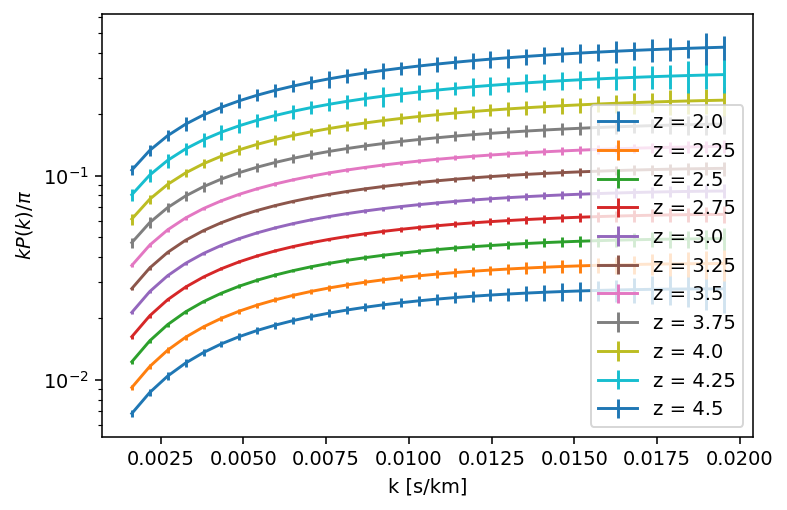

In [6]:
data.plot_p1d()

### Setup emulators

Each run will have its own emulator, that will be the only different thing in the run

In [7]:
runs={}
runs['GP']={'emulator':gp_emulator.GPEmulator(archive=archive,drop_sim=drop_sim,
                                              kmax_Mpc=kmax_Mpc,ndeg=polyfit_ndeg)}

Use custom archive provided by the user
Selected custom emulator


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.27 seconds


In [8]:
runs['NN']={'emulator':nn_emulator.NNEmulator(archive=archive,drop_sim=drop_sim,
                                              kmax_Mpc=kmax_Mpc,ndeg=polyfit_ndeg)}

Selected custom emulator
Use custom archive provided by the user
Training samples in archive : 9900


### Set free parameters and theory

In [9]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=3
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [10]:
for label,run in runs.items():
    run['theory']=lya_theory.Theory(zs=data.z,emulator=run['emulator'],free_param_names=free_param_names)

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [11]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=0.2
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
for label,run in runs.items():
    run['likelihood']=like=likelihood.Likelihood(data=data,theory=run['theory'],
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor)

run GP
As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4
ln_tau_2 = 0.0 , -0.2 , 0.2
ln_sigT_kms_2 = 0.0 , -0.4 , 0.4
ln_gamma_2 = 0.0 , -0.4 , 0.4
ln_kF_2 = 0.0 , -0.4 , 0.4
chi2 = 43.87744673886326


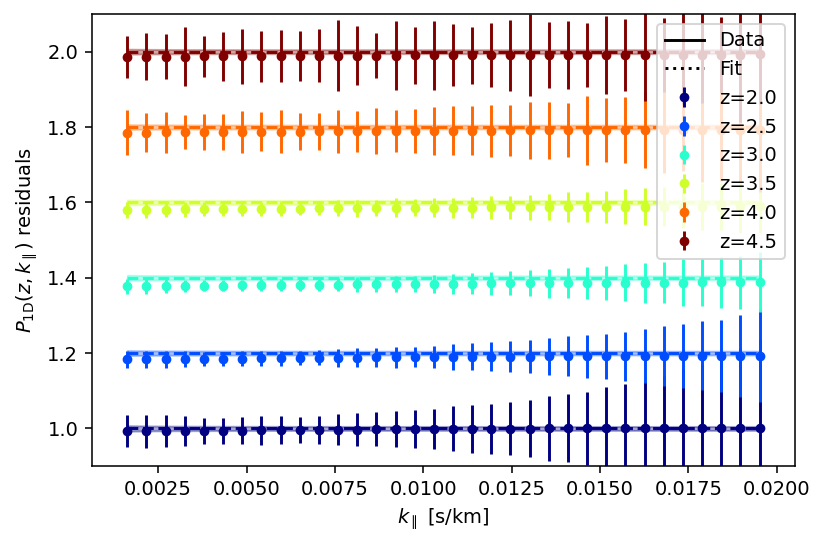

----------------
run NN
As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4
ln_tau_2 = 0.0 , -0.2 , 0.2
ln_sigT_kms_2 = 0.0 , -0.4 , 0.4
ln_gamma_2 = 0.0 , -0.4 , 0.4
ln_kF_2 = 0.0 , -0.4 , 0.4
chi2 = 49.384620645605146


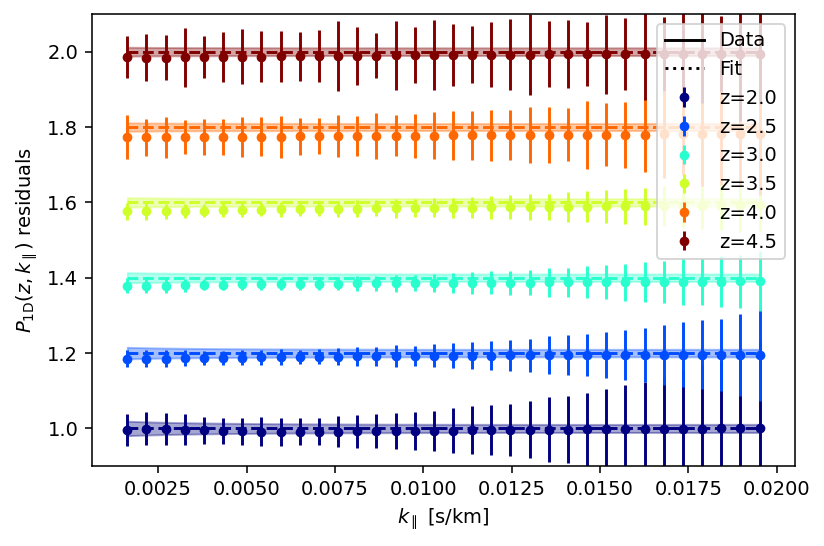

----------------


In [12]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for label,run in runs.items():
    print('run',label)
    like=run['likelihood']
    for p in like.parameters_from_sampling_point(values=test_values):
        print(p.info_str(all_info=True))
    print('chi2 =',like.get_chi2(values=test_values))
    like.plot_p1d(values=test_values,residuals=True,plot_every_iz=2)
    print('----------------')

### Run iminuit minimizer

In [13]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.0
ini_values=2*ini_sigma*np.random.random(len(free_param_names))+0.5-ini_sigma
for label,run in runs.items():
    print('minimize run',label)
    # what is the chi2 of the starting point?
    ini_chi2=run['likelihood'].get_chi2(values=ini_values)
    run['minimizer']=iminuit_minimizer.IminuitMinimizer(run['likelihood'],ini_values=ini_values)
    run['minimizer'].minimize(compute_hesse=True)
    # what is the chi2 of the best-fit? (should be close to 0)
    best_fit_values=np.array(run['minimizer'].minimizer.values)
    best_chi2=run['likelihood'].get_chi2(values=best_fit_values)
    print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2))
    

minimize run GP
chi2 improved from 43.87744673886326 to 0.17274728020611652
minimize run NN
chi2 improved from 49.384620645605146 to 0.6346322918761476


run GP


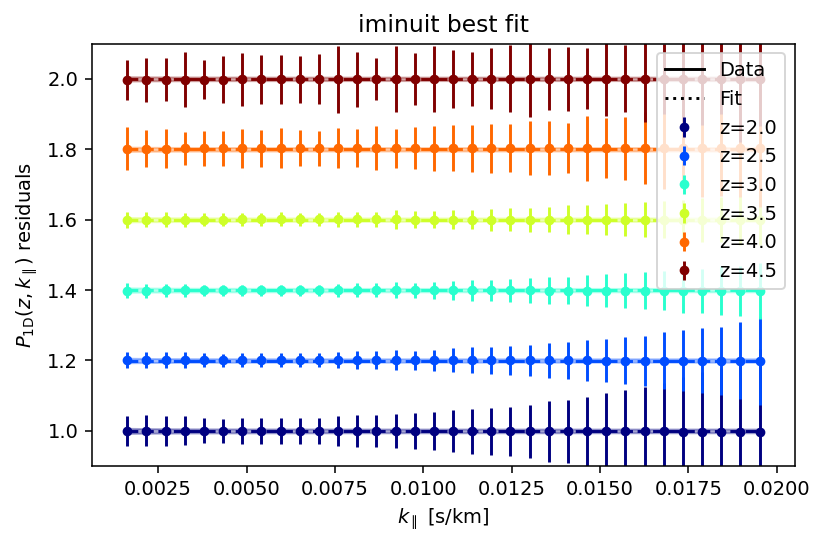

run NN


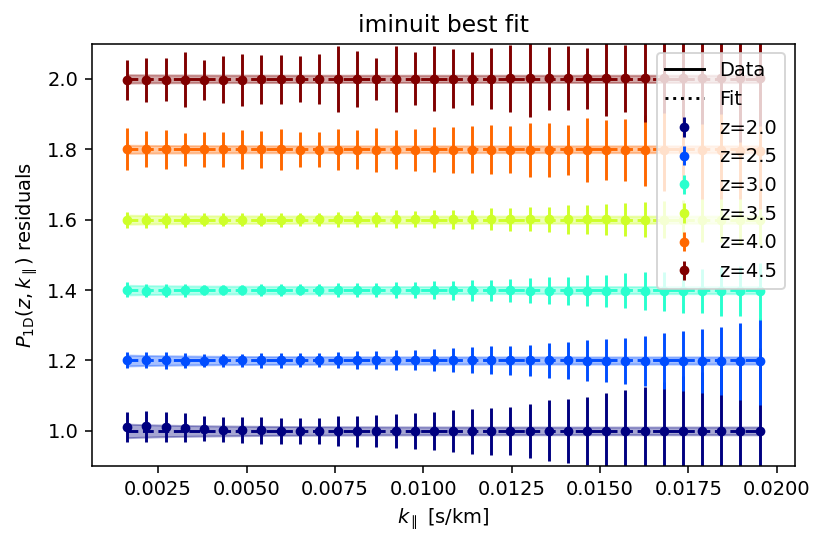

In [14]:
for label,run in runs.items():
    print('run',label)
    run['minimizer'].plot_best_fit(plot_every_iz=2)

run GP
run NN


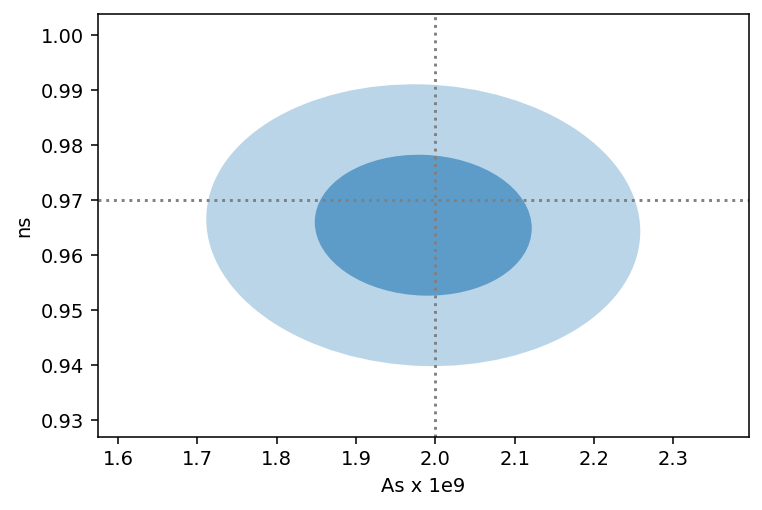

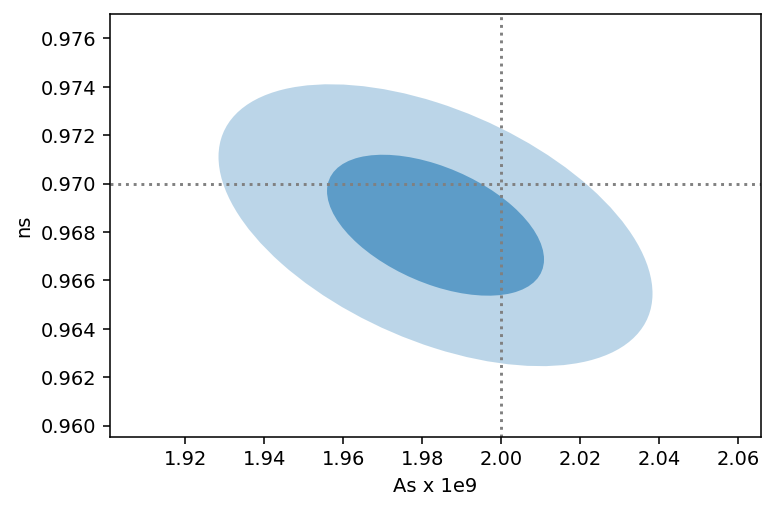

In [15]:
for label,run in runs.items():
    plt.figure()
    print('run',label)
    run['minimizer'].plot_ellipses('As','ns')
    plt.savefig(label+'_As_ns.png')